# Análisis de votaciones de los diputados argentinos usando aprendizaje no supervisado con Pycaret

## Introducción

Ayer estaba leyendo sobre cómo 12 diputados radicales crearon un nuevo bloque, separándose de Cambiemos (https://www.ambito.com/politica/ucr/ruptura-la-una-docena-diputados-formara-su-propio-bloque-diputados-n5330249). Si bien esto no es nada nuevo en la política argentina (y seguramente tampoco en la mayoría de los países), hizo que vuelva a mi mente una pregunta ¿es posible clasificar a los diputados por su comportamiento en las votaciones independientemente del partido político por el que se presentan?

En machine learning es posible realizar una primera clasificación según el tipo de aprendizaje:
1. Aprendizaje supervisado
2. Aprendizaje no supervisado 
3. Aprendizaje reforzado

Simplificando, podemos decir que en el aprendizaje supervisado el modelo aprende a realizar un mapeo entre variables de entrada y un "target". Es decir que ya tenemos identificados los resultados y queremos intentar que el modelo aprenda a predecirlos.

En cambio en el aprendizaje no supervisado no contamos con "labels" sino que dejamos que el modelo utilice las diferentes variables para extraer relaciones en los datos.

Finalmente en el aprendizaje reforzado tenemos un "agente" que opera en un determinado entorno y que debe aprender a operar en él utilizando feedback.

Este problema de diputados podría plantearse como un problema supervisado si, por ejemplo, intentásemos que el modelo prediga el partido al que pertenece en base a sus votaciones.

Pero como en este caso lo que queremos ver es cómo se ubican los diputados según sus votos independientemente del partido al que representan, pareciese ser más conveniente utilizar aprendizaje no supervisado (y esto es lo que vamos a hacer).


Ya tenemos una idea de qué queremos hacer, ahora nos faltan los datos. Después de un googleo rápido encontré que la "Honorable Cámara de Diputados de la Nación" tiene una página de datos abiertos y que podemos explorar las votaciones nominales de los periodos 129 a 137: https://datos.hcdn.gob.ar/dataset/votaciones_nominales. Como una primera aproximación vamos a trabajar con los datos del periodo 137. Como queremos hacer un prototipo rápido, vamos a utilizar Pycaret para realizar el modelo.


Pycaret es una librería de Python open source, que permite tanto preparar los datos como armar un modelo en cuestión de minutos, con muy pocas líneas de código. Es una librería muy interesante para experimentar e iterar rápidamente, para tener una primera idea de qué podría funcionar y en qué concentrarse para mejorar los resultados.

Y con esto terminamos la introducción y nos "ponemos manos a la obra". En el siguiente enlace pueden encontrar el notebook con el codigo:  https://github.com/aitorporcel/exploracion-diputados

## Instalando pycaret

El primer paso es instalar pycaret. En este caso estoy realizando la exploración en google colab, pero si lo están corriendo localmente es recomendable que generen un nuevo entorno virtual antes de instalar las librerías.

In [1]:
!pip install pycaret

     |████████████████████████████████| 288 kB 15.0 MB/s 
     |████████████████████████████████| 6.8 MB 68.1 MB/s 
     |████████████████████████████████| 15.5 MB 58.0 MB/s 
     |████████████████████████████████| 167 kB 71.8 MB/s 
     |████████████████████████████████| 1.3 MB 72.6 MB/s 
     |████████████████████████████████| 261 kB 68.6 MB/s 
     |████████████████████████████████| 1.7 MB 74.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 113 kB 86.7 MB/s 
     |████████████████████████████████| 2.0 MB 65.2 MB/s 
     |████████████████████████████████| 3.1 MB 62.7 MB/s 
     |████████████████████████████████| 596 kB 74.8 MB/s 
     |████████████████████████████████| 675 kB 68.5 MB/s 
     |████████████████

## Cargamos las librerias a utilizar

Ahora vamos a cargar las librerías a utilizar. Para este ejemplo simple sólo vamos a necesitar cargar pandas y pycaret clustering.

In [2]:
import pandas as pd
from pycaret.clustering import *

## Descargamos los datos a utilizar

Como dijimos, vamos a trabajar inicialmente con los datos del periodo 137. Vemos que tenemos 2 conjuntos de datos: uno correspondientes a "cabecera" y otro con "detalles". Vamos a descargar los dos csv para explorarlos. Los enlaces son:
* Datos cabecera: https://datos.hcdn.gob.ar/dataset/2e08ab84-09f4-4aac-86b3-9573ca9810db/resource/59c05ba8-ad0a-4d55-803d-20e3fe464d0b/download/actas-cabecera-137-2.0.csv
* Datos detalle: https://datos.hcdn.gob.ar/dataset/2e08ab84-09f4-4aac-86b3-9573ca9810db/resource/f86728ed-d4b9-479e-b939-a9841fd6d8d3/download/actas-detalle-137-2.0.csv

In [3]:
!wget https://datos.hcdn.gob.ar/dataset/2e08ab84-09f4-4aac-86b3-9573ca9810db/resource/59c05ba8-ad0a-4d55-803d-20e3fe464d0b/download/actas-cabecera-137-2.0.csv
!wget https://datos.hcdn.gob.ar/dataset/2e08ab84-09f4-4aac-86b3-9573ca9810db/resource/f86728ed-d4b9-479e-b939-a9841fd6d8d3/download/actas-detalle-137-2.0.csv

--2021-12-07 17:38:32--  https://datos.hcdn.gob.ar/dataset/2e08ab84-09f4-4aac-86b3-9573ca9810db/resource/59c05ba8-ad0a-4d55-803d-20e3fe464d0b/download/actas-cabecera-137-2.0.csv
Resolving datos.hcdn.gob.ar (datos.hcdn.gob.ar)... 45.230.20.47, 2801:15:b000:2::47
Connecting to datos.hcdn.gob.ar (datos.hcdn.gob.ar)|45.230.20.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20576 (20K) [text/csv]
Saving to: ‘actas-cabecera-137-2.0.csv’

actas-cabecera-137- 100%[===================>]  20.09K  92.4KB/s    in 0.2s    

2021-12-07 17:38:34 (92.4 KB/s) - ‘actas-cabecera-137-2.0.csv’ saved [20576/20576]

--2021-12-07 17:38:34--  https://datos.hcdn.gob.ar/dataset/2e08ab84-09f4-4aac-86b3-9573ca9810db/resource/f86728ed-d4b9-479e-b939-a9841fd6d8d3/download/actas-detalle-137-2.0.csv
Resolving datos.hcdn.gob.ar (datos.hcdn.gob.ar)... 45.230.20.47, 2801:15:b000:2::47
Connecting to datos.hcdn.gob.ar (datos.hcdn.gob.ar)|45.230.20.47|:443... connected.
HTTP request sent, awaiti

## Carga de datos y exploracion preliminar

Ahora cargamos los dos csv que acabamos de descargar para explorarlos rápidamente.

In [4]:
cabecera_137 = pd.read_csv("actas-cabecera-137-2.0.csv")
detalles_137 = pd.read_csv("actas-detalle-137-2.0.csv")

El archivo de detalles tiene 7 columnas, indicando qué votó cada diputado en cada una de las votaciones (identificadas como acta_id), junto con algunos datos adicionales como el bloque y el distrito.

In [5]:
detalles_137.shape

(25700, 7)

In [6]:
detalles_137.head()

,acta_id,acta_detalle_id,diputado_nombre,persona_id,bloque,distrito_nombre,voto
0,3864,1139025,. NO INCORPORADO Legislador 2,,PRO,C.A.B.A.,AUSENTE
1,3864,1139026,ABDALA DE MATARAZZO Norma Amanda,,Frente Cívico por Santiago,Santiago del Estero,AFIRMATIVO
2,3864,1139027,ACERENZA Samanta María Celeste,,PRO,Buenos Aires,NEGATIVO
3,3864,1139028,AICEGA Juan,,PRO,Buenos Aires,NEGATIVO
4,3864,1139029,ALLENDE Walberto Enrique,,Todos Juntos por San Juan,San Juan,AFIRMATIVO


Si bien vamos a explorar los tipos de cada columna, vamos a ver más adelante que Pycaret se encarga de eso por nosotros.

In [7]:
detalles_137.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25700 entries, 0 to 25699
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   acta_id          25700 non-null  int64 
 1   acta_detalle_id  25700 non-null  int64 
 2   diputado_nombre  25643 non-null  object
 3   persona_id       25700 non-null  object
 4   bloque           25700 non-null  object
 5   distrito_nombre  25700 non-null  object
 6   voto             25700 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.4+ MB


Acá hay algo llamativo, tenemos 376 nombres únicos de diputados pero en el congreso sólo hay 257. La respuesta a esto la vamos a encontrar cuando analicemos el dataset de cabecera.

In [8]:
detalles_137.nunique()

acta_id              100
acta_detalle_id    25700
diputado_nombre      376
persona_id             1
bloque                42
distrito_nombre       24
voto                   4
dtype: int64

Vamos a verificar duplicados que siempre es una buena práctica cuando exploramos por primera vez un dataset. Además en caso de tener duplicados recibiremos un error a la hora de pivotear la tabla usando pandas.

In [9]:
#Verificamos duplicados -> Ok
detalles_137.drop("acta_detalle_id", axis = 1).duplicated().sum()

0

Ahora vamos a explorar un poco los datos de cabecera. Tenemos 20 columnas, pero primero nos vamos a concentrar en la columna fecha.

In [10]:
cabecera_137.shape

(100, 20)

In [11]:
cabecera_137.head()

,sesion_id,acta_id,nroperiodo,tipo_periodo,reunion,sesion,tipo_sesion,numero,fecha,hora,base_mayoria,tipo_mayoria,titulo,resultado,presidente_nombre,presidente_id,votos_afirmativos,votos_negativos,abstenciones,ausentes
0,HCDN137R01,3864,137,Ordinario,1,1,Especial,1,2019-04-04,13:27,Votos Emitidos,Dos tercios,Tratamiento - Exención de impuesto a las ganan...,NEGATIVO,MONZÓ Emilio,NaN,130,91,0,35
1,HCDN137R01,3865,137,Ordinario,1,1,Especial,2,2019-04-04,15:04,Votos Emitidos,Dos tercios,Tratamiento - Expedientes vinculados a tarifas,NEGATIVO,MONZÓ Emilio,NaN,120,96,0,40
2,HCDN137R01,3866,137,Ordinario,1,1,Especial,3,2019-04-04,17:49,Votos Emitidos,Dos tercios,Tratamiento - Expedientes sobre temas varios,NEGATIVO,MONZÓ Emilio,NaN,104,89,0,63
3,HCDN137R03,3867,137,Ordinario,3,3,Tablas,1,2019-04-24,17:19,Votos Emitidos,Más de la mitad,Expediente 5094-D-18 OD:590.Votación en genera...,AFIRMATIVO,MONZÓ Emilio,NaN,150,7,7,92
4,HCDN137R03,3868,137,Ordinario,3,3,Tablas,2,2019-04-24,17:21,Votos Emitidos,Más de la mitad,Expedientes 6516-D-18 OD 595 y 2844-D-18 OD:66...,AFIRMATIVO,MONZÓ Emilio,NaN,165,0,11,80


La columna fecha es del tipo object así que vamos a transformarla a datetime para poder revisarla más en detalle.

In [12]:
cabecera_137.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sesion_id          100 non-null    object 
 1   acta_id            100 non-null    int64  
 2   nroperiodo         100 non-null    int64  
 3   tipo_periodo       100 non-null    object 
 4   reunion            100 non-null    int64  
 5   sesion             100 non-null    int64  
 6   tipo_sesion        100 non-null    object 
 7   numero             100 non-null    int64  
 8   fecha              100 non-null    object 
 9   hora               100 non-null    object 
 10  base_mayoria       100 non-null    object 
 11  tipo_mayoria       100 non-null    object 
 12  titulo             100 non-null    object 
 13  resultado          100 non-null    object 
 14  presidente_nombre  100 non-null    object 
 15  presidente_id      0 non-null      float64
 16  votos_afirmativos  100 non-

In [13]:
cabecera_137["fecha"] = pd.to_datetime(cabecera_137["fecha"], infer_datetime_format=True)

In [14]:
cabecera_137["fecha"].describe()

count                     100
unique                      9
top       2019-11-20 00:00:00
freq                       26
first     2019-04-04 00:00:00
last      2020-01-29 00:00:00
Name: fecha, dtype: object

Podemos ver que el periodo 137 incluye votaciones entre el 04–04–2019 y el 2020–01–29, pero los nuevos diputados comienzan sus funciones el 10–12–2019. Esto hace que tengamos diputados que dejaron sus bancas y otros que asumieron (esto explica que tengamos 376 diputados en vez de 257 como esperábamos). Como simplificación sólo vamos a analizar las votaciones de los diputados antes de la asunción para ser consistentes (aunque sería conveniente en un futuro agregar los datos del periodo 136, para tener el periodo 2017–2019 completo).

Extraemos los números de votación que se realizaron previo al 2019-12-10 para utilizarlo luego como filtro en nuestro dataset.

In [15]:
acta_ids = cabecera_137["acta_id"][cabecera_137["fecha"] <= pd.Timestamp(2019,12,9)]

In [16]:
detalles_137 = detalles_137[detalles_137["acta_id"].isin(acta_ids)]

In [17]:
detalles_137.nunique()

acta_id               69
acta_detalle_id    17733
diputado_nombre      259
persona_id             1
bloque                36
distrito_nombre       24
voto                   4
dtype: int64

Ahora si tenemos un número más lógico de diputados, cercano al 257 que esperábamos. Vamos a pivotear la tabla para tener las votaciones como columnas y los votos de los diputados en las filas.

In [18]:
df = detalles_137.pivot(index = "diputado_nombre", columns = "acta_id", values = "voto").reset_index()

In [19]:
df.columns.name = "index"

In [20]:
df.head()

index,diputado_nombre,3864,3865,3866,3867,3868,3869,3870,3871,3872,3873,3874,3875,3876,3877,3878,3879,3880,3881,3882,3883,3884,3885,3886,3887,3888,3889,3890,3891,3892,3893,3894,3895,3896,3897,3898,3899,3900,3901,3902,3903,3904,3905,3906,3907,3908,3909,3910,3911,3912,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE
1,. NO INCORPORADO Legislador 2,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABDALA DE MATARAZZO Norma Amanda,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,ABSTENCION,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,NEGATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AUSENTE,AUSENTE,AUSENTE,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,NEGATIVO,AFIRMATIVO
3,ACERENZA Samanta María Celeste,NEGATIVO,NEGATIVO,NEGATIVO,AFIRMATIVO,AFIRMATIVO,ABSTENCION,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AUSENTE,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,NEGATIVO,AFIRMATIVO,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,AUSENTE,ABSTENCION,AFIRMATIVO,AFIRMATIVO,NEGATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO
4,AICEGA Juan,NEGATIVO,NEGATIVO,NEGATIVO,AFIRMATIVO,AFIRMATIVO,NEGATIVO,AFIRMATIVO,AFIRMATIVO,NEGATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,NEGATIVO,AUSENTE,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AUSENTE,AUSENTE,AFIRMATIVO,NEGATIVO,AFIRMATIVO,NEGATIVO,NEGATIVO,AFIRMATIVO,AFIRMATIVO,NEGATIVO,AUSENTE,AUSENTE,AUSENTE,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO,AFIRMATIVO


La fila 0 es llamativa ya que no tiene el nombre del diputado. Vamos a controlar que no tengamos nulos en ninguna fila (ya que al filtrar antes de la asunción de los diputados nuevos, salvo excepciones no deberíamos tener nulos en las votaciones).

In [21]:
df.isna().sum().head()

index
diputado_nombre    1
3864               3
3865               3
3866               3
3867               3
dtype: int64

In [22]:
max(df.isna().sum())

3

Tenemos hasta 3 nulos por votación y además tenemos más diputados de los que esperábamos. Si bien lo correcto sería investigar esta situación particular, como simplificación vamos a hacer el drop de las filas con nulos para poder seguir avanzando.

In [23]:
df.shape

(260, 70)

In [24]:
df = df.dropna()
df.shape

(254, 70)

Vamos a trabajar con las votaciones de 254 diputados, bastante cerca del número que esperábamos (257). Para una primera exploración parece suficiente.

## Modelo

Finalmente llegamos al modelo. como dijimos vamos a usar Pycaret para realizar un modelo rápido. Como algoritmo vamos a usar k-means, que es uno de los modelos de clustering disponibles en la librería y es uno de los métodos más simples de aprendizaje no supervisado. Básicamente lo que hace el algoritmo es identificar un número de centroides y agrupar los datos al centroide más cercano.

Como no buscamos realizar predicciones sino simplemente explorar el comportamiento de los diputados, vamos a utilizar el dataset en su totalidad (saltándonos el paso de separar en entrenamiento y testeo).

El primer paso es realizar el setup del entorno. Vamos a indicar un session_id para que los resultados sean reproducibles y vamos a ignorar la columna de diputado_nombre, ya que no queremos que el modelo lo utilice como un feature.

Como estamos frente a un problema de clusterización importamos sólo la librería de clusterización (from pycaret.clustering import *). 
Pycaret permite resolver problemas de:
* Classification
* Regression
* Clustering
* Anomaly Detection
* Natural Language Processing
* Association Rule Mining
* Time Series (por ahora en beta)

Al correr la celda de setup, Pycaret identificará el tipo de cada columna y nos pedirá que confirmemos si los tipos son correctos. La función de setup tiene diversas opciones para realizar distintas normalizaciones y transformaciones, e incluso para crear nuevos features en base a los existentes. Por ahora lo vamos a mantener simple y vamos a utilizar los valores por defecto.

Si quieren aprender más de pycaret, en el github de la librería hay varios ejemplos muy interesantes: https://github.com/pycaret/pycaret/tree/master/tutorials


In [25]:
cluster = setup(data = df, session_id = 1, ignore_features=["diputado_nombre"])

,Description,Value
0,session_id,1
1,Original Data,"(254, 70)"
2,Missing Values,False
3,Numeric Features,0
4,Categorical Features,69
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(254, 218)"
9,CPU Jobs,-1


Como dijimos, Pycaret se encarga de toda la transformación por nosotros. Si queremos ver cómo quedó el dataset luego de la transformación, podemos hacerlo desde get_config para acceder a la variable global que genera la librería.

In [26]:
get_config("X").head()

,3864_AFIRMATIVO,3864_AUSENTE,3864_NEGATIVO,3865_AFIRMATIVO,3865_AUSENTE,3865_NEGATIVO,3866_AFIRMATIVO,3866_AUSENTE,3866_NEGATIVO,3867_ABSTENCION,3867_AFIRMATIVO,3867_AUSENTE,3867_NEGATIVO,3868_ABSTENCION,3868_AFIRMATIVO,3868_AUSENTE,3869_ABSTENCION,3869_AFIRMATIVO,3869_AUSENTE,3869_NEGATIVO,3870_ABSTENCION,3870_AFIRMATIVO,3870_AUSENTE,3870_NEGATIVO,3871_ABSTENCION,3871_AFIRMATIVO,3871_AUSENTE,3871_NEGATIVO,3872_ABSTENCION,3872_AFIRMATIVO,3872_AUSENTE,3872_NEGATIVO,3873_ABSTENCION,3873_AFIRMATIVO,3873_AUSENTE,3874_AFIRMATIVO,3874_AUSENTE,3874_NEGATIVO,3875_ABSTENCION,3875_AFIRMATIVO,...,3920_ABSTENCION,3920_AFIRMATIVO,3920_AUSENTE,3920_NEGATIVO,3921_ABSTENCION,3921_AFIRMATIVO,3921_AUSENTE,3922_ABSTENCION,3922_AFIRMATIVO,3922_AUSENTE,3923_ABSTENCION,3923_AFIRMATIVO,3923_AUSENTE,3924_AFIRMATIVO,3924_AUSENTE,3925_ABSTENCION,3925_AFIRMATIVO,3925_AUSENTE,3926_AFIRMATIVO,3926_AUSENTE,3927_ABSTENCION,3927_AFIRMATIVO,3927_AUSENTE,3927_NEGATIVO,3928_AFIRMATIVO,3928_AUSENTE,3929_ABSTENCION,3929_AFIRMATIVO,3929_AUSENTE,3930_ABSTENCION,3930_AFIRMATIVO,3930_AUSENTE,3931_ABSTENCION,3931_AFIRMATIVO,3931_AUSENTE,3931_NEGATIVO,3932_ABSTENCION,3932_AFIRMATIVO,3932_AUSENTE,3932_NEGATIVO
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


Utilizamos entonces la función create_model y el argumento kmeans. Como número de clusters vamos a proponer inicialmente 2 (suponiendo que se van a distribuir como oficilialismo vs oposición).

In [27]:
model = create_model('kmeans', num_clusters = 2)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1882,58.1981,2.0452,0,0,0


Utilizando plot_model pycaret nos permite representar gráficamente los clusters en dos dimensiones, utilizando PCA. PCA (Principal Component Analysis) es una técnica utilizada para reducir la dimensionalidad rotando los ejes del dataset (más info en https://machinelearningmastery.com/principal-components-analysis-for-dimensionality-reduction-in-python/).
De esta manera podemos ver gráficamente la cercanía en el comportamiento de las votaciones de cada diputado. Al correrlo en el google colab pueden utilizar el gráfico interactivo para ver el nombre de cada diputado, representado por un punto. El color indica el cluster al que pertenece.

In [28]:
plot_model(model, 'cluster', label = False)

Nota: al realizar reducción dimensional también se debe tener en cuenta que se pierde poder explicativo. En este dataset, el PCA para dos dimensiones explica aproximadamente un 42% de la varianza total.

Pycaret trae una serie de opciones para analizar gráficamente distintos aspectos del modelo. Por ejemplo podemos usar la opción "elbow". Elbow es un método heurístico que ayuda a encontrar el número apropiado de clusters en el dataset. No pareciese apreciarse un valor óptimo a simple vista, lo cual es coincidente con lo que vemos en el gráfico anterior, que no hay clusters claros.

Si quieren leer más sobre esta técnica pueden hacerlo en https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

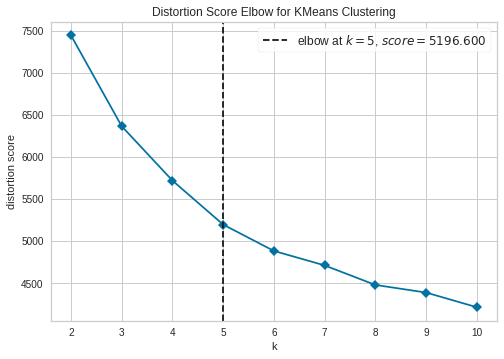

In [29]:
plot_model(model, plot = 'elbow')

Finalmente, si queremos guardar el dataset indicando a qué cluster pertenece cada diputado podemos utilizar la función predict_model.

In [30]:
predictions = predict_model(model, data = df)

In [31]:
predictions[["diputado_nombre", "Cluster"]].head()

index,diputado_nombre,Cluster
2,ABDALA DE MATARAZZO Norma Amanda,Cluster 1
3,ACERENZA Samanta María Celeste,Cluster 1
4,AICEGA Juan,Cluster 1
5,ALLENDE Walberto Enrique,Cluster 1
6,ALONSO Laura Valeria,Cluster 1


## Reflexiones finales

En este post pudimos ver rápidamente una forma de agrupar a los diputados según sus votos en las diferentes sesiones, pero es importante hacer algunas aclaraciones: 
* Sólo tomamos el periodo 137, lo correcto sería sumar también la sesión 136 para tener dos años de votaciones para los mismos diputados.
* Podríamos tomar distintos periodos y ver si se observa una polarización más fuerte en las votaciones.
* Propusimos la utilización de 2 clusters esperando una distribución oficialismo vs oposición, pero como pudimos ver (tanto visualmente en el gráfico de PCA1 vs PCA como en el gráfico de Elbow) pareciese que 2 clusters no logran un agrupamiento claro.
* Se trata de un análisis rápido para mostrar lo que se puede hacer utilizando Pycaret en pocas líneas de código (el armado del modelo solo fueron 2 líneas, el resto fue exploración del dataset e interpretación de los resultados).
* Este análisis y el post fueron realizados en una tarde, así que posiblemente tengan errores y cosas a mejorar, cualquier recomendación es más que bienvenida.


## Extra: Exploración PCA

In [32]:
from sklearn.decomposition import PCA
X = get_config("X")
pca = PCA(n_components=5)
pca.fit(X)
print(pca.explained_variance_ratio_)

[0.25015193 0.17489001 0.10892794 0.05247029 0.04665952]


In [33]:
pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]

0.42504194